Systematic Uncertainty Modelling
===

In the `Neural_Likelihood_Ratio_Estimation.ipynb` notebook, we left out the nuisance parameter piece of the parameterized density ratio decomposition:

$$g_c(x|\alpha) = \frac{p_c(x|\alpha)}{p_c(x)} = \prod_m \frac{p_c(x|\alpha_m^{eval})}{p_c(x)}$$

where the second equality assumes that **the effect of various sources of uncertainty in the model can be factorized**. This is another density ratio estimation problem, but instead of training m $\alpha-$parameterized NNs, we use a HistFactory-style interpolation generalized to a per-event formulation:

$$\frac{p_c(x|\alpha_m^{eval})}{p_c(x)} = \begin{cases}
    \left(\frac{p_c(x|\alpha_m^+)}{p_c(x)}\right)^{\alpha_m^\text{eval}}& \alpha_m^\text{eval}>1\\
    1+\sum_{n=1}^6c_n\cdot (\alpha_m^\text{eval})^n& -1\leq\alpha_m^\text{eval}\leq 1\\
    \left(\frac{p_c(x|\alpha_m^-)}{p_c(x)}\right)^{-\alpha_m^\text{eval}}& \alpha_m^\text{eval}<-1\\
    \end{cases}$$

where $\alpha=\{\alpha_m^{eval}\}$ and for each nuisance parameter $m$, we have three simulation models - $p_c(x), p_c(x|\alpha_m^+), p_c(x|\alpha_m^-)$. Naturally, this still requires NNs to estimate the density ratios:

$$\frac{p_c(x|\alpha_m^+)}{p_c(x)} \, , \frac{p_c(x|\alpha_m^-)}{p_c(x)}$$

**These are the density ratios that we will estimate using NNs in this notebook.**
Two ratios corresponding to each $\alpha_m^\pm$ will be trained for each systematic uncertainty indexed by $m$ and for each channel $c$ to build the final parameterized model, 

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\sum_c G_c(\alpha) \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot G_c(\alpha) \cdot \nu_c \cdot g_c(x|\alpha) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)}$$

The full workflow for building $\mu, \alpha-$parameterized density ratios is represented in the flowchart below:

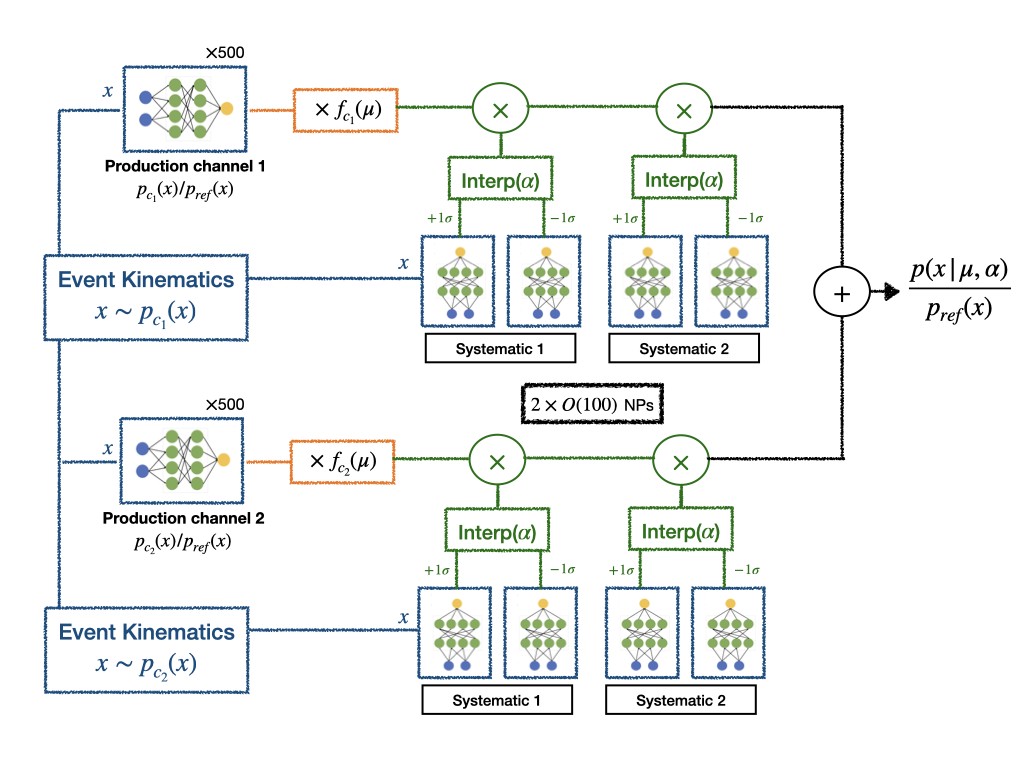

In [1]:
import os, sys, importlib
# sys.path.append('/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/')

import nsbi_common_utils
from nsbi_common_utils import plotting, training
from nsbi_common_utils.training import TrainEvaluate_NN, TrainEvaluatePreselNN

from utils import calculate_preselection_observable, preselection_using_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
import pickle
import yaml
import random
import numpy as np

from coffea.analysis_tools import PackedSelection

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

hep.style.use(hep.style.ATLAS)

/data/jaySandesara/NSBI_workflow_tutorial/src/nsbi_common_utils/plotting.py:11: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-06-23 21:32:52.062534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750714372.078772  561574 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750714372.083347  561574 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-23 21:32:52.102098: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instr

In [2]:
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)

In [3]:
# path prefix for general save directory
path_prefix = config['path_prefix']

# sub-path for saving cached data used between modules
path_saved_data = config['path_saved_data']
saved_data = f'{path_prefix}{path_saved_data}'

# Path for loading preselection NN model
path_preselection_NN_model = config['path_preselection_NN_model']
path_to_saved_presel_model = f'{path_prefix}{path_preselection_NN_model}'

# Input features for training
columns = config["columns"]

channels_binned = config["channels_binned"]

# Subset of the features to standardize before training
columns_scaling = config["columns_scaling"]

# Get the dictionary of labels to processes
labels_dict = config["labels_dict"]

# Signal processes in the model
signal_processes = config["signal_processes"]

# Background processes in the model
background_processes = config["background_processes"]

mix_model_hypotheses = config["mix_model_hypotheses"]
ref_processes = config["ref_processes"]

# float factors multiplying the probabilities in the preselection score observable 
pre_factor_preselection_score = config["pre_factor_preselection_score"]


In [4]:
dict_systs = config["dict_systs"]
print(dict_systs)

{'TES': {'process': ['htautau', 'ttbar', 'ztautau'], 'directions': ['up', 'dn']}}


In [5]:
# Load the datasets corresponding to systematic variations
datasets_syst = {}

for syst in dict_systs:

    datasets_syst[syst] = {}

    for direction in dict_systs[syst]['directions']:

        datasets_syst[syst][direction] = pd.read_hdf(f"{saved_data}df_{syst}_{direction}.h5", key="dataset")


dataset_nom = pd.read_hdf(f"{saved_data}df_nominal.h5", key="dataset")

pred_NN_incl_nom = np.load(f"{saved_data}pred_NN_incl.npy")
presel_score_nom = calculate_preselection_observable(pred_NN_incl_nom, 
                                                     labels_dict, signal_processes, 
                                                     background_processes, 
                                                     pre_factor_dict = pre_factor_preselection_score)

dataset_nom['presel_score'] = presel_score_nom

list_syst = [key for key in dict_systs]
print(list_syst)

['TES']


In [6]:
importlib.reload(sys.modules['nsbi_common_utils.training'])
from nsbi_common_utils.training import TrainEvaluatePreselNN

num_classes = len(labels_dict)

for syst in datasets_syst:

    for direction in datasets_syst[syst]:

        # Skip preselection score calculation if already done in a previous round
        if 'presel_score' in list(datasets_syst[syst][direction].columns): continue

        dataset = datasets_syst[syst][direction]
    
        preselectionTraining = TrainEvaluatePreselNN(dataset, num_classes, columns, columns_scaling)
        preselectionTraining.get_trained_model(path_to_saved_presel_model)
        pred_NN_incl = preselectionTraining.predict(dataset)

        presel_score = calculate_preselection_observable(pred_NN_incl, labels_dict, 
                                                         signal_processes, background_processes)

        datasets_syst[syst][direction]['presel_score'] = presel_score

        # Overwrite saved dataframe with preselection score saved for future iterations
        datasets_syst[syst][direction].to_hdf(f"{saved_data}df_{syst}_{direction}.h5", key="dataset", mode="w")

        del dataset, presel_score, pred_NN_incl
        

In [7]:
preselection_cuts = np.load(f"{saved_data}preselection_cuts.npy", allow_pickle=True).item()

channel_selections = {'CR': {'observable': 'presel_score', 
                             'lower_presel': -999, 
                             'upper_presel': preselection_cuts.get('lower'), 
                             'num_bins': 4},
                      'SR_binned': {'observable': 'presel_score', 
                                    'lower_presel': preselection_cuts.get('upper'), 
                                    'upper_presel': -999,
                                    'num_bins': 2},
                      'SR': {'observable': None, 
                             'upper_presel': preselection_cuts.get('upper'), 
                             'lower_presel': preselection_cuts.get('lower')}}


dataset_nom_channels = preselection_using_score(dataset_nom, channel_selections)

datasets_syst_channels = {}
    
for syst in datasets_syst:

    datasets_syst_channels[syst] = {}
    
    for direction in datasets_syst[syst]:

        datasets_syst_channels[syst][direction] = preselection_using_score(datasets_syst[syst][direction], 
                                                                           channel_selections)


del dataset_nom, datasets_syst

Signal and Control Regions
===

The SR needs additional density ratios to be trained, whereas the CR follows the standard procedure of template histogram building.

In [8]:
hist_binned = {}
bins = {}
min_presel_bin = {}
max_presel_bin = {}
observable = {}

for channel, dict_observable in channel_selections.items():

    fit_observable = channel_selections[channel]['observable']
    if fit_observable == None: continue
    
    with open(f"{saved_data}hist_binned_{channel}.pkl", "rb") as fp:
        hist_binned[channel] = pickle.load(fp)

    bins[channel] = np.load(f"{saved_data}bins_{channel}.npy")
    observable[channel] = fit_observable

    min_presel_bin[channel] = bins[channel][0]
    max_presel_bin[channel] = bins[channel][-1]

In [9]:
hist_var = {}

for channel, dict_observable in channel_selections.items():

    if channel not in channels_binned: continue

    hist_var[channel] = {}
    
    for process in labels_dict:
        
        hist_var[channel][process] = {}
        
        for syst in dict_systs:
    
            hist_var[channel][process][syst] = {}
    
            for direction in ['up','dn']:
    
                hist_var[channel][process][syst][direction] = {}
                
                mask_process = (datasets_syst_channels[syst][direction][channel].type==process)
            
                if (process not in dict_systs[syst]['process']) | (direction not in dict_systs[syst]['directions']):
                    hist_var[channel][process][syst][direction] = np.ones_like(hist_CR[process])
    
                else:
    
                    dataset_process = datasets_syst_channels[syst][direction][channel][mask_process].copy()
                    
                    hist_var[channel][process][syst][direction] = np.histogram(np.clip(dataset_process[observable[channel]].ravel(), 
                                                                        min_presel_bin[channel], max_presel_bin[channel]), 
                                                                        weights = dataset_process['weights'].ravel(),
                                                                        bins = bins[channel])[0]/hist_binned[channel][process]
    
                    del dataset_process
    

In [10]:
# Save the Control Region variation histogram
with open(f"{saved_data}hist_binned_variations.pkl", "wb") as fp:
    pickle.dump(hist_var, fp)

Density ratio training
===

Now we train the NNs to predict two ratios,

$$\frac{p_c(x|\alpha_m^+)}{p_c(x)} \, , \frac{p_c(x|\alpha_m^-)}{p_c(x)}$$

for each nuisance parameter $\alpha_m$, for each process $p_c$ that is affected by the corresponding nuisance parameter.


In [11]:
importlib.reload(sys.modules['nsbi_common_utils.training'])
from nsbi_common_utils.training import TrainEvaluate_NN

ref_processes = np.load(f"{saved_data}ref_processes.npy")

dataset_syst_process = {}
NN_training_syst_process = {}

# rnd_seed_traintestsplit = 42 # can also be randomized, fixed for now
rnd_seed_traintestsplit = random.randint(0, 2**32 - 1)


for process in labels_dict:
    
    NN_training_syst_process[process] = {}

    mask_process_nom = (dataset_nom_channels['SR'].type==process)
    dataset_den = dataset_nom_channels['SR'][mask_process_nom].copy()
    
    for syst in dict_systs:

        if process not in dict_systs[syst]['process']:
            print(f"Nothing to train for {process} in {syst} uncertainty")
            continue
        
        NN_training_syst_process[process][syst] = {}
        
        for direction in dict_systs[syst]['directions']:

            mask_process_syst = (datasets_syst_channels[syst][direction]['SR'].type==process)
            
            # Save paths
            top_path = f'{path_prefix}output_training_systematics/'

            output_name = f'{process}_{syst}_{direction}'
            output_dir = f'{top_path}general_output_{process}_{syst}_{direction}'
            path_to_ratios = f'{top_path}output_ratios_{process}_{syst}_{direction}/'
            path_to_figures = f'{top_path}output_figures_{process}_{syst}_{direction}/'
            path_to_models = f'{top_path}output_model_params_{process}_{syst}_{direction}/'

            dataset_num = datasets_syst_channels[syst][direction]['SR'][mask_process_syst].copy()

            dataset_num['train_labels'] = 1
            dataset_den['train_labels'] = 0

            dataset_num['weights_normed'] = dataset_num['weights'].to_numpy() / dataset_num['weights'].sum()
            dataset_den['weights_normed'] = dataset_den['weights'].to_numpy() / dataset_den['weights'].sum()
            
            # Build a training dataset for the training of p_<process_type>/p_<ref_processes> density ratio
            dataset_syst_process = pd.concat([dataset_num, dataset_den])

            
            NN_training_syst_process[process][syst][direction] = TrainEvaluate_NN(dataset_syst_process, 
                                                                                   dataset_syst_process['weights_normed'],
                                                                                   dataset_syst_process['train_labels'],
                                                                                   columns, 
                                                                                   columns_scaling, rnd_seed_traintestsplit,
                                                                                   [syst+'_'+direction, process], output_dir, output_name, 
                                                                                    path_to_figures=path_to_figures,
                                                                                    path_to_ratios=path_to_ratios, 
                                                                                    path_to_models=path_to_models)

    del dataset_num, dataset_den
                




 Training for TES systematic for process htautau 




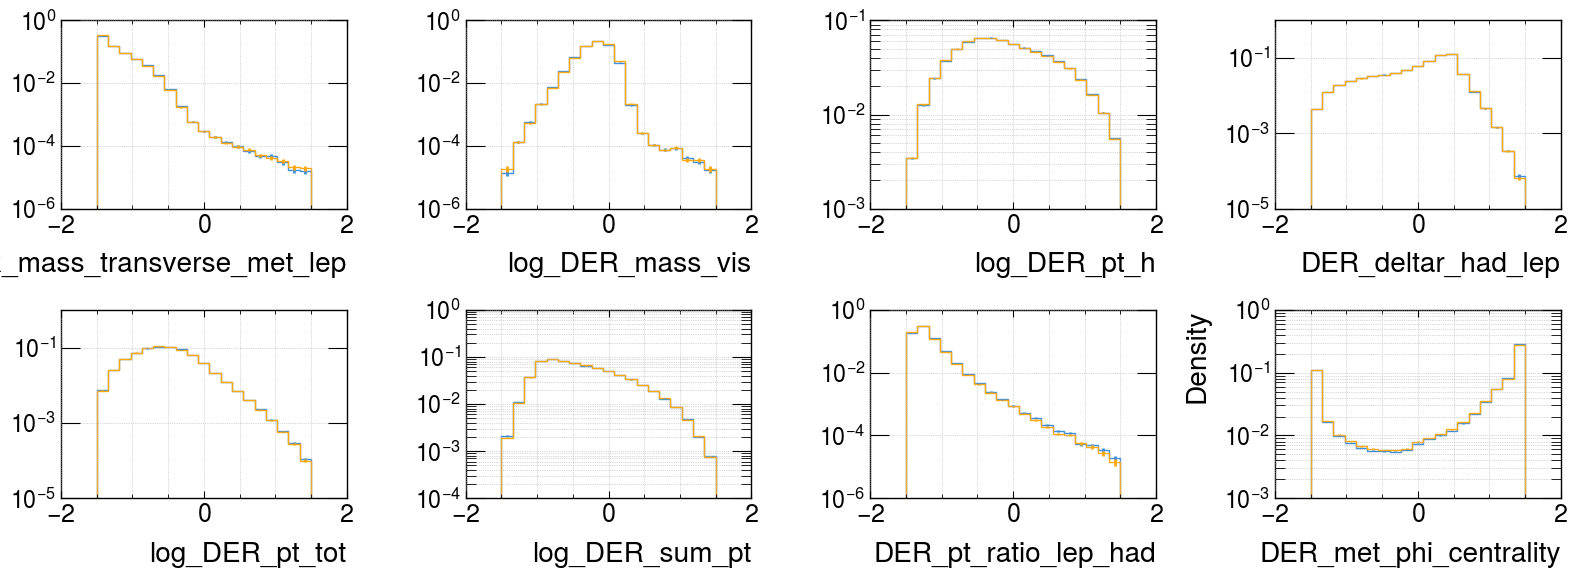

Sum of weights of class 0: 0.6999988555908203
Sum of weights of class 1: 0.7000009417533875
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks


2025-06-23 22:36:17.061759: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_3', 8 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_2', 16 bytes spill stores, 20 bytes spill loads



Finished Training
/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/output_training_systematics/output_model_params_htautau_TES_up/model_scaler.bin


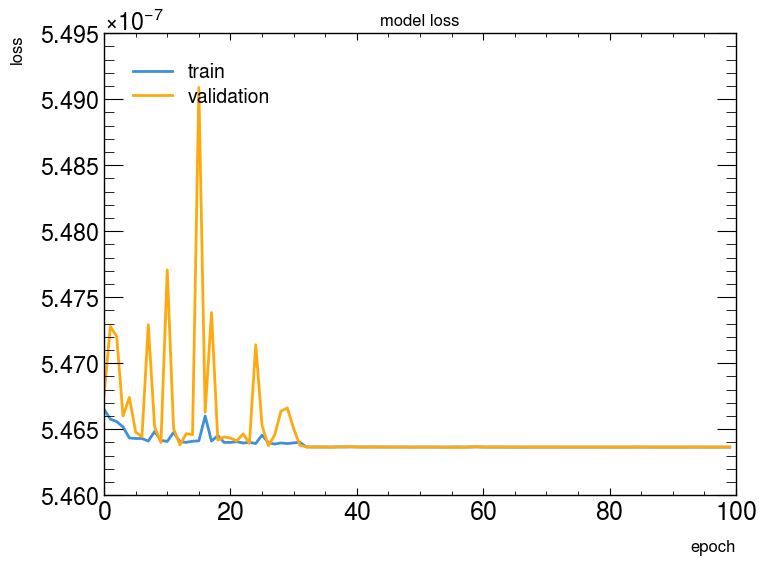

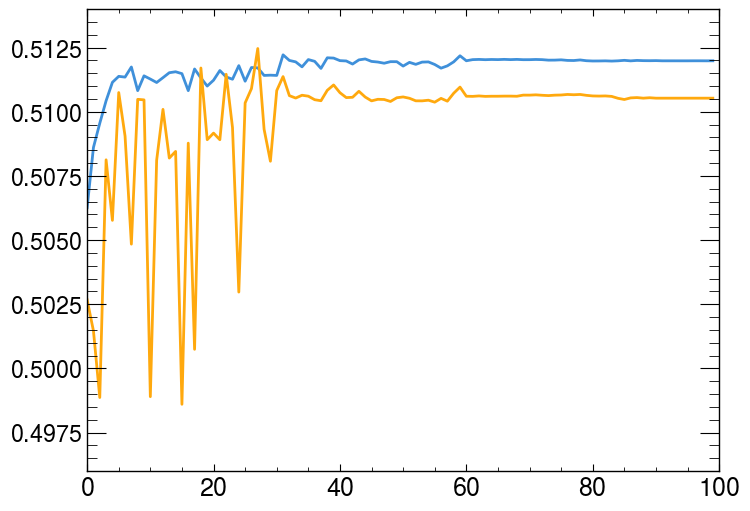

178/178 - 2s - 10ms/step
77/77 - 1s - 10ms/step
254/254 - 2s - 9ms/step
The sum of PDFs is 0.998752772808075


<Figure size 800x600 with 0 Axes>

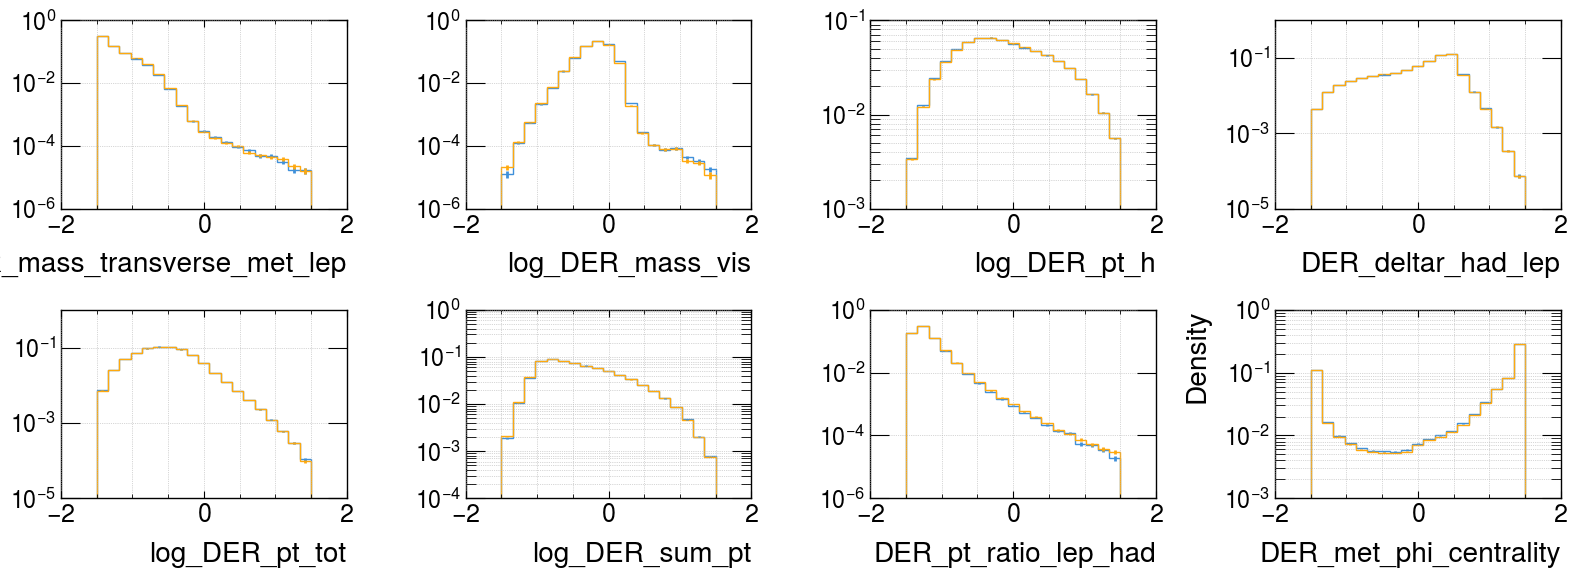

Sum of weights of class 0: 0.6999982595443726
Sum of weights of class 1: 0.7000012993812561
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks


2025-06-23 22:43:39.049980: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_3', 8 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_2', 16 bytes spill stores, 20 bytes spill loads

2025-06-23 22:43:43.484876: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_2', 4 bytes spill stores, 4 bytes spill loads



Finished Training
/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/output_training_systematics/output_model_params_htautau_TES_dn/model_scaler.bin


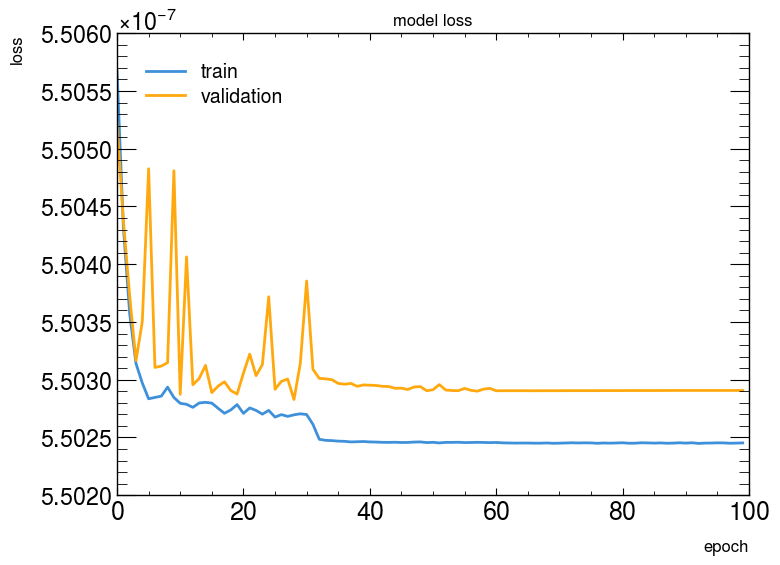

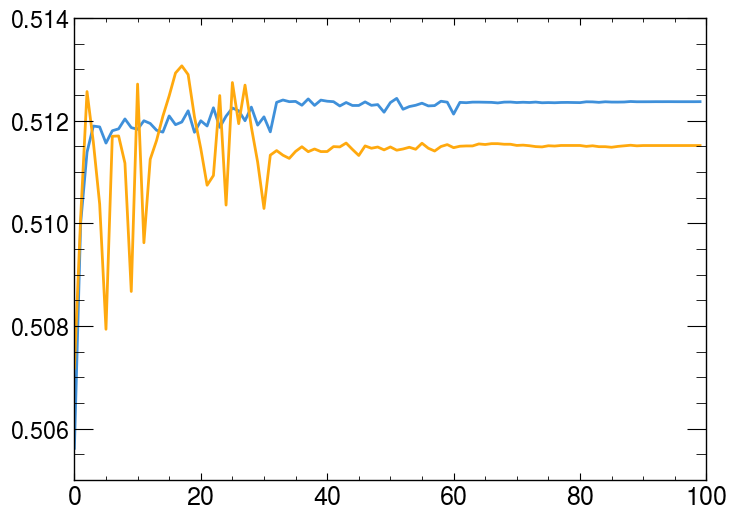

177/177 - 2s - 10ms/step
76/76 - 1s - 10ms/step
252/252 - 2s - 9ms/step
The sum of PDFs is 0.9994502067565918


 Training for TES systematic for process ztautau 




<Figure size 800x600 with 0 Axes>

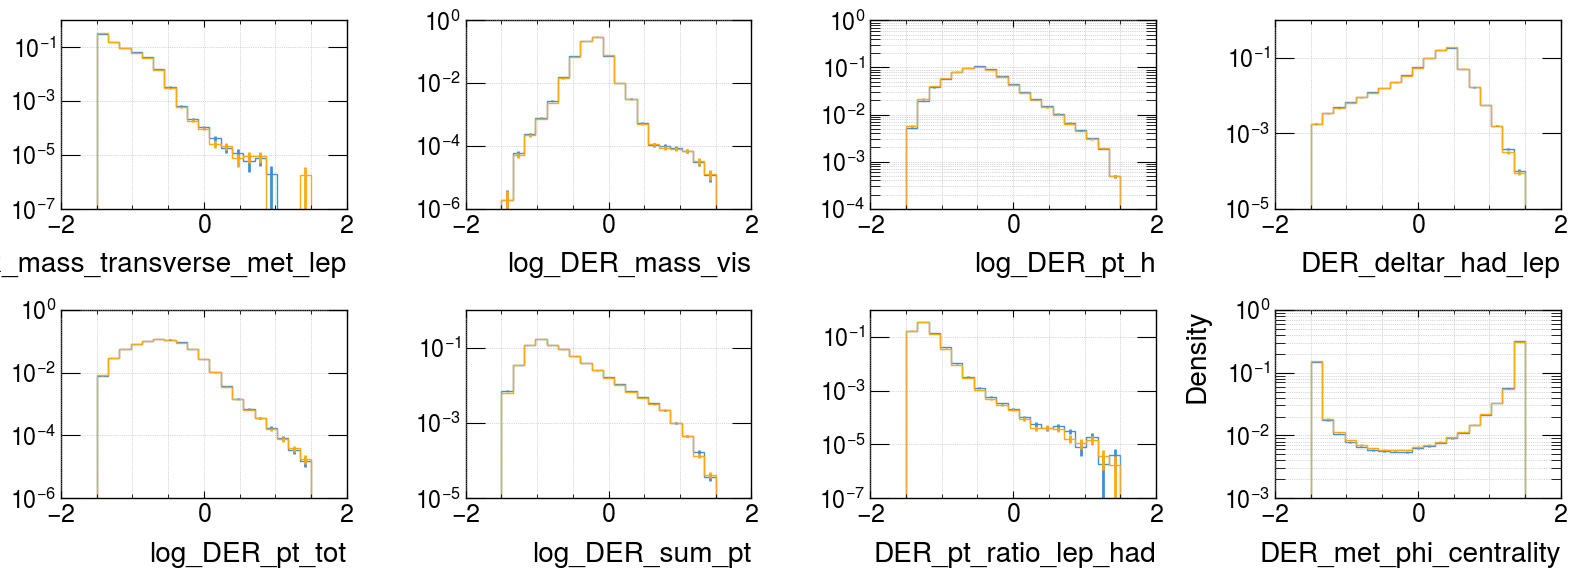

Sum of weights of class 0: 0.6999989151954651
Sum of weights of class 1: 0.7000002264976501
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks


2025-06-23 22:50:54.180681: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_3', 8 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_2', 16 bytes spill stores, 20 bytes spill loads

2025-06-23 22:50:56.378789: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_2', 4 bytes spill stores, 4 bytes spill loads



Finished Training
/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/output_training_systematics/output_model_params_ztautau_TES_up/model_scaler.bin


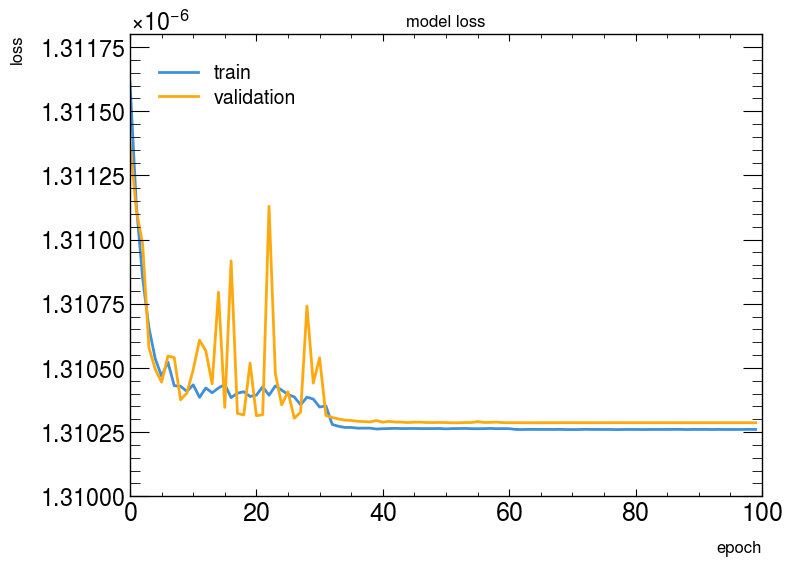

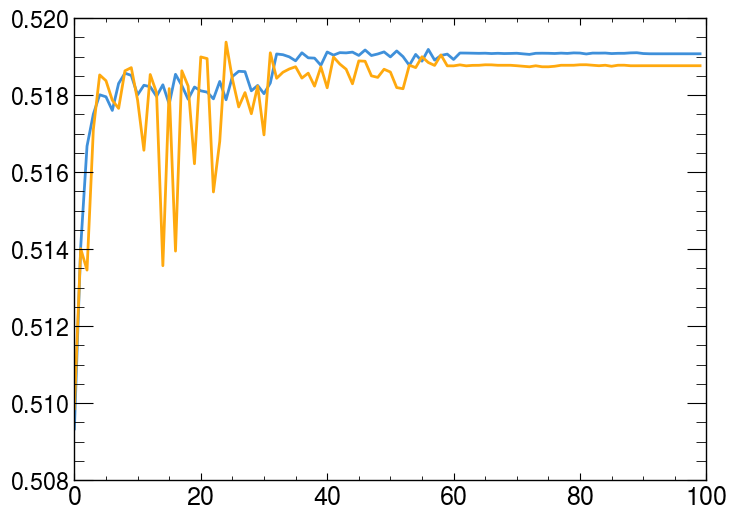

74/74 - 1s - 13ms/step
32/32 - 0s - 14ms/step
106/106 - 1s - 10ms/step
The sum of PDFs is 0.9997747540473938


<Figure size 800x600 with 0 Axes>

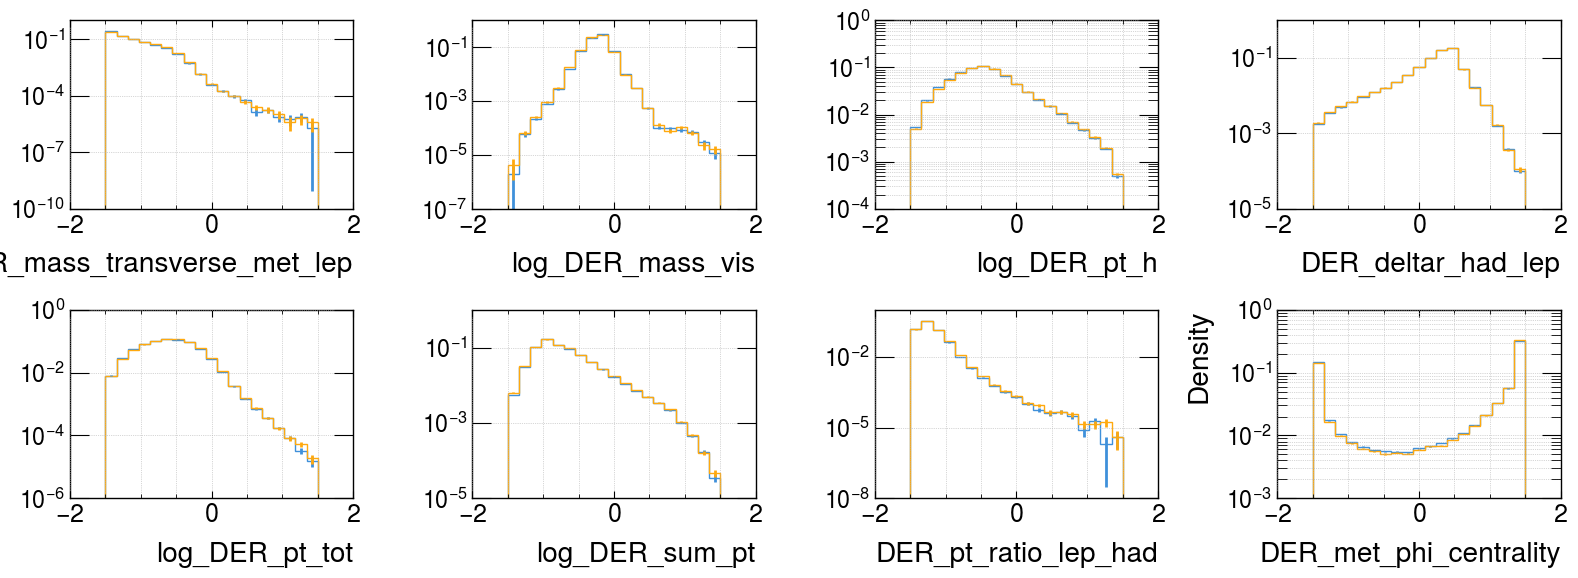

Sum of weights of class 0: 0.7000008821487427
Sum of weights of class 1: 0.6999999284744263
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks


2025-06-23 22:54:11.283739: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_3', 8 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_2', 16 bytes spill stores, 20 bytes spill loads



Finished Training
/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/output_training_systematics/output_model_params_ztautau_TES_dn/model_scaler.bin


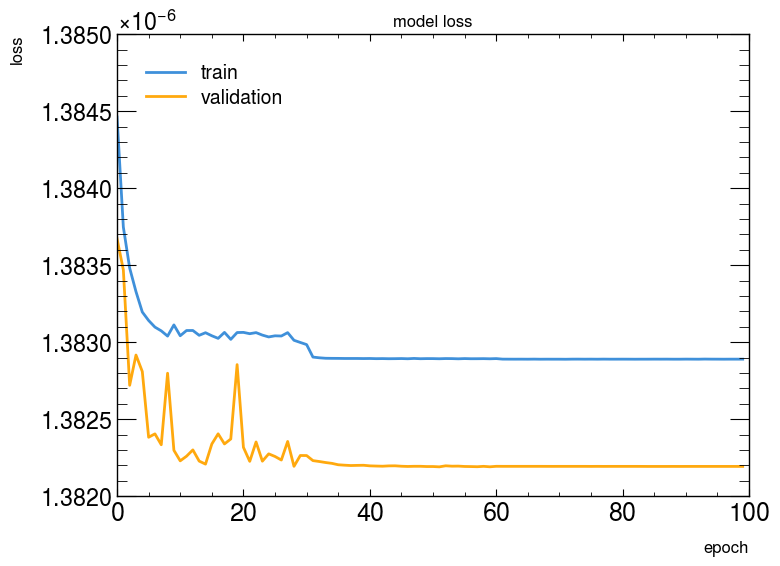

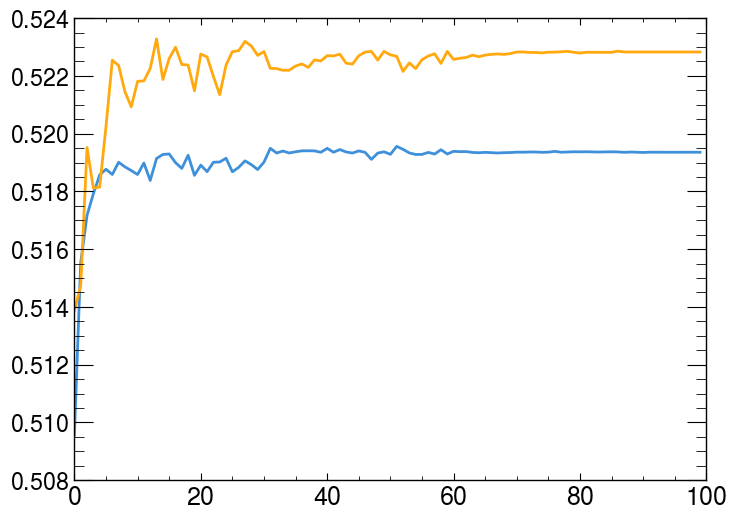

71/71 - 1s - 13ms/step
31/31 - 0s - 14ms/step
101/101 - 1s - 10ms/step
The sum of PDFs is 1.0007072687149048


 Training for TES systematic for process ttbar 




<Figure size 800x600 with 0 Axes>

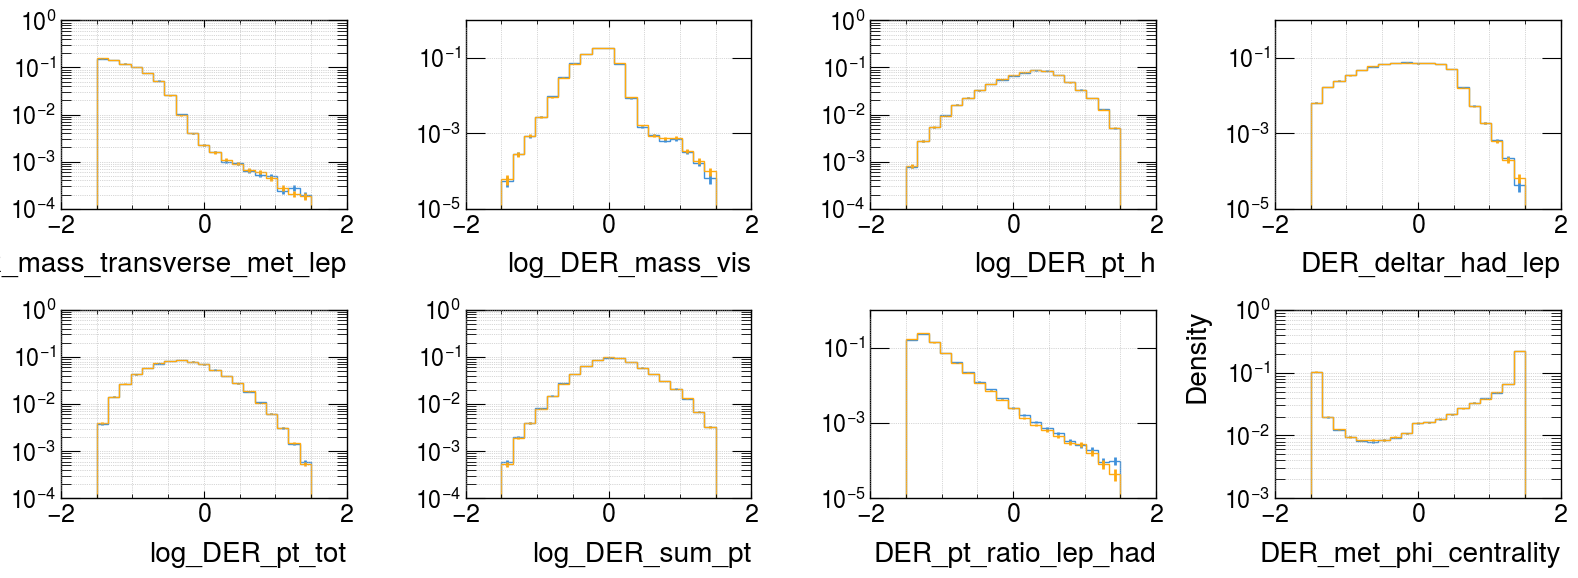

Sum of weights of class 0: 0.700011670589447
Sum of weights of class 1: 0.7000020146369934
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Finished Training
/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/output_training_systematics/output_model_params_ttbar_TES_up/model_scaler.bin


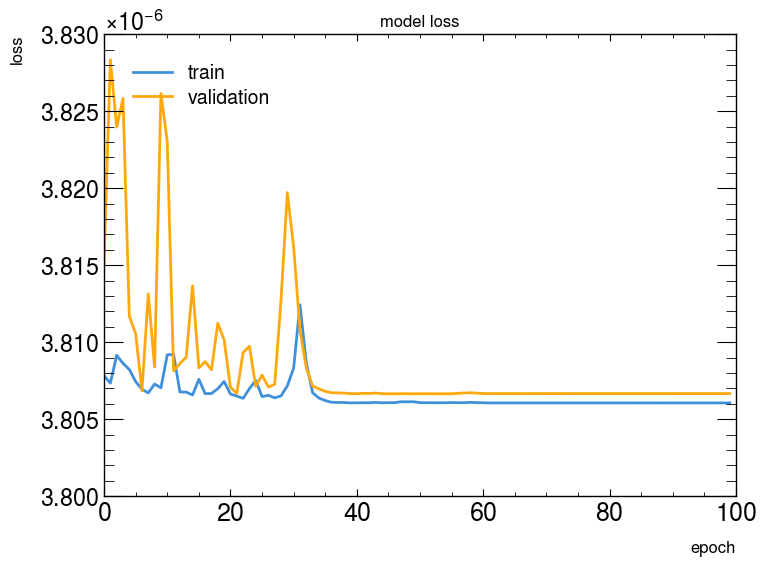

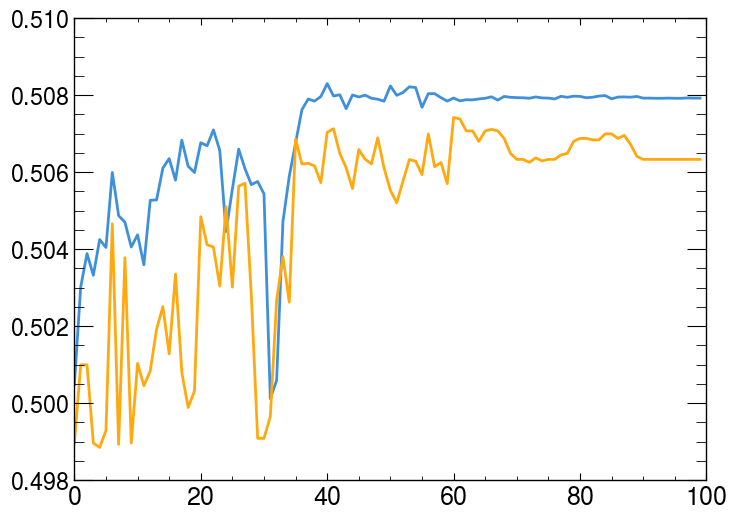

26/26 - 1s - 22ms/step
11/11 - 0s - 25ms/step
37/37 - 0s - 13ms/step
The sum of PDFs is 0.9999191164970398


<Figure size 800x600 with 0 Axes>

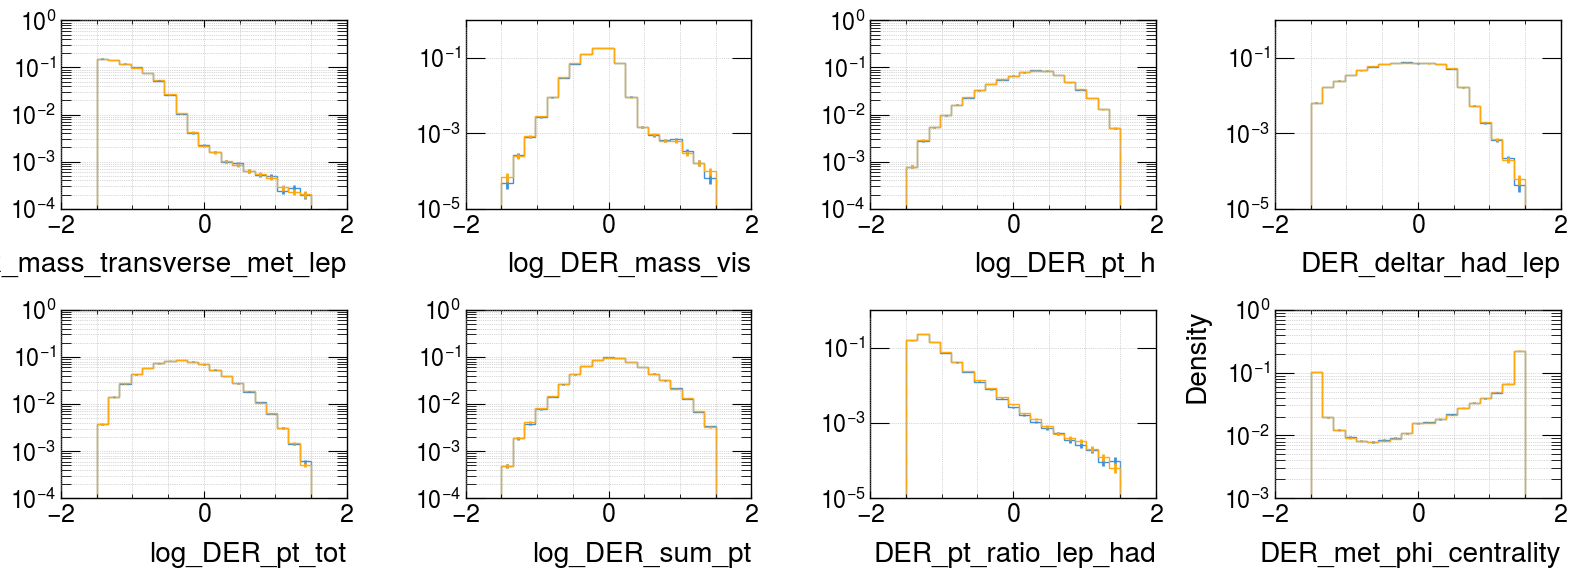

Sum of weights of class 0: 0.700011670589447
Sum of weights of class 1: 0.699997067451477
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks


2025-06-23 22:58:44.286543: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_2', 4 bytes spill stores, 4 bytes spill loads



Finished Training
/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/output_training_systematics/output_model_params_ttbar_TES_dn/model_scaler.bin


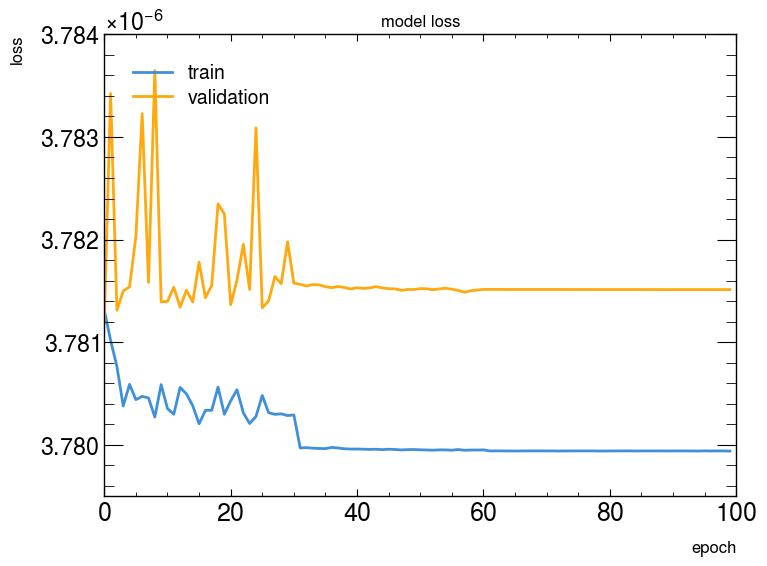

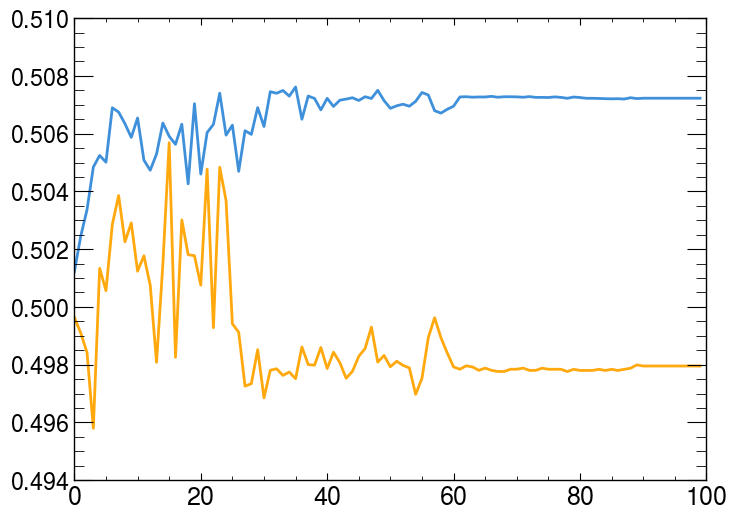

26/26 - 1s - 21ms/step
11/11 - 0s - 24ms/step
37/37 - 0s - 13ms/step
The sum of PDFs is 0.9987285137176514


<Figure size 800x600 with 0 Axes>

In [23]:
# For systematic uncertainty variations, we use a calibration layer to regularize the small fluctuations in density ratio output
doCalibration = False

for process in labels_dict:
    
    for syst in dict_systs:

        print(f"\n\n Training for {syst} systematic for process {process} \n\n")

        if process not in dict_systs[syst]['process']:
            print(f"Nothing to train for {process} in {syst} uncertainty")
            continue
        
        for direction in dict_systs[syst]['directions']:

            # Train the density ratio NN
            NN_training_syst_process[process][syst][direction].train (   hidden_layers        = 4, 
                                                                         neurons              = 1000, 
                                                                         number_of_epochs     = 100, 
                                                                         batch_size           = 4096, 
                                                                         learning_rate        = 0.1, 
                                                                         scalerType           = 'MinMax', 
                                                                         calibration          = doCalibration, 
                                                                         num_bins_cal         = 100, 
                                                                         callback             = True, 
                                                                         callback_patience    = 30, 
                                                                         callback_factor      = 0.01,
                                                                         verbose              = 0,
                                                                         plot_scaled_features = True)    
            
            NN_training_syst_process[process][syst][direction].test_normalization ( )    
            


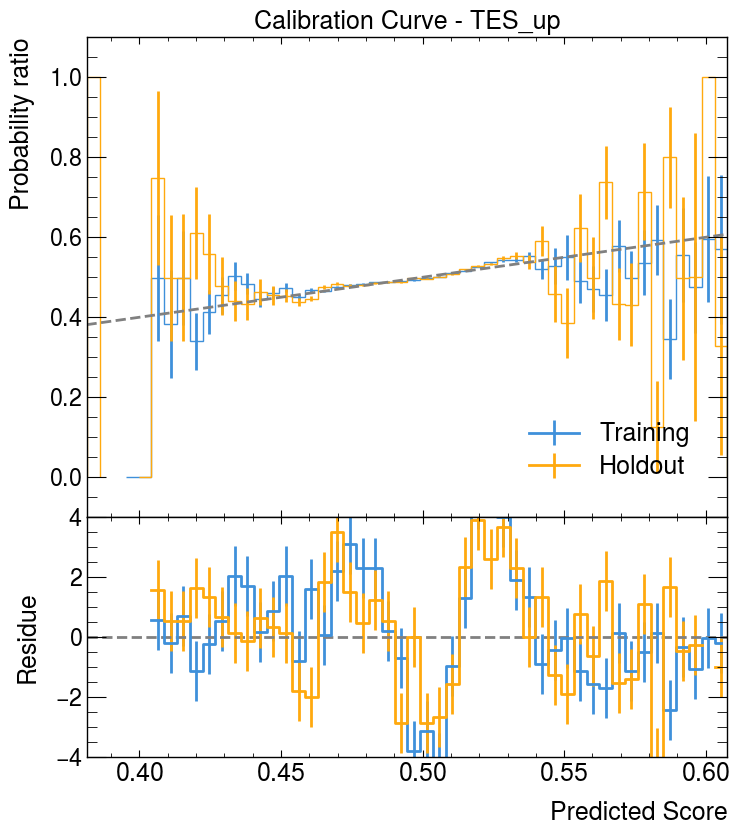

<Figure size 800x600 with 0 Axes>

In [32]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["TES"]["up"].make_calib_plots(nbins=num_bins_cal, observable='score')

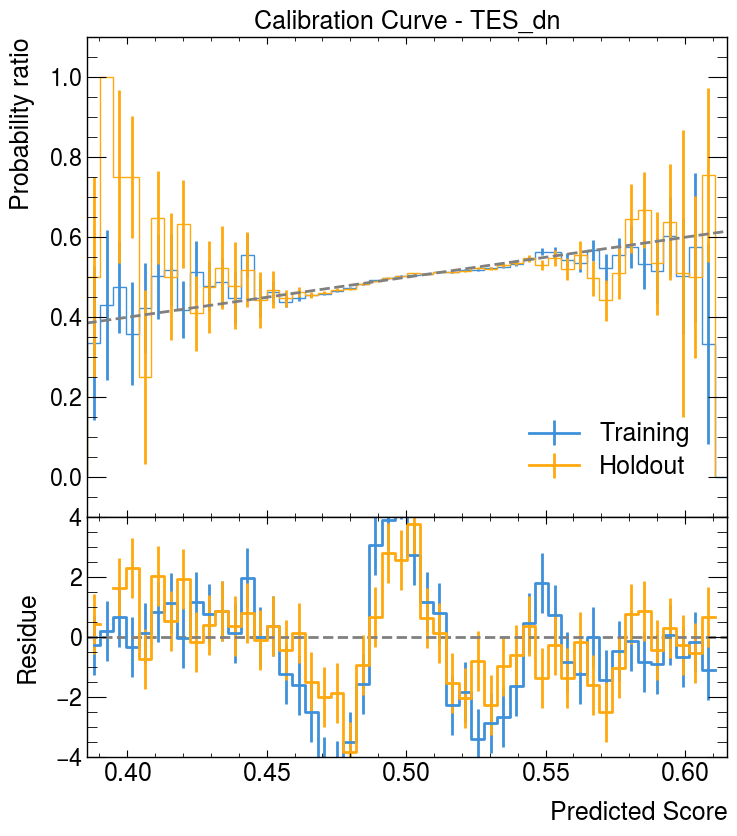

<Figure size 800x600 with 0 Axes>

In [31]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["TES"]["dn"].make_calib_plots(nbins=num_bins_cal, observable='score')


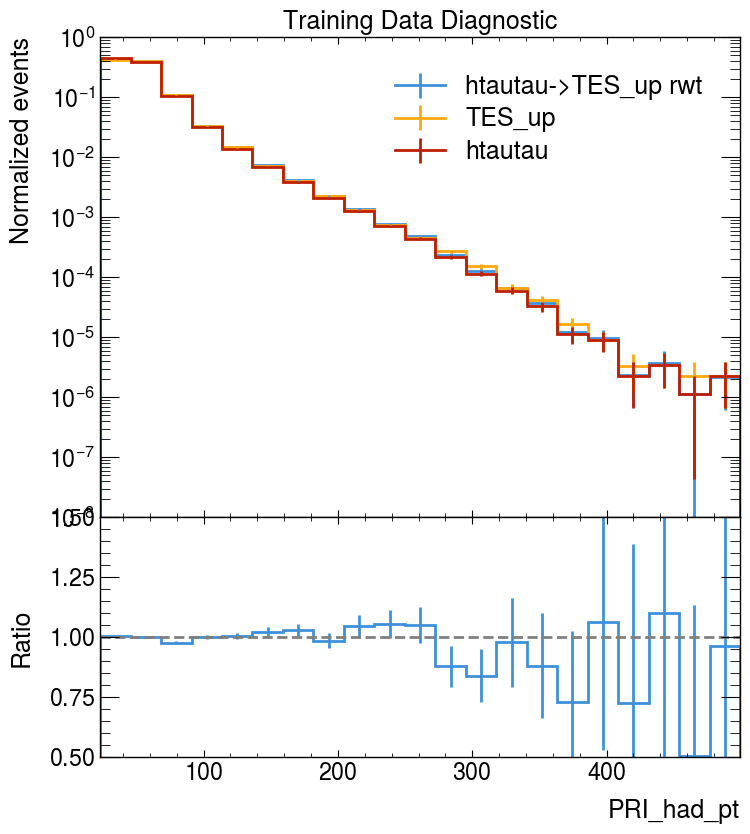

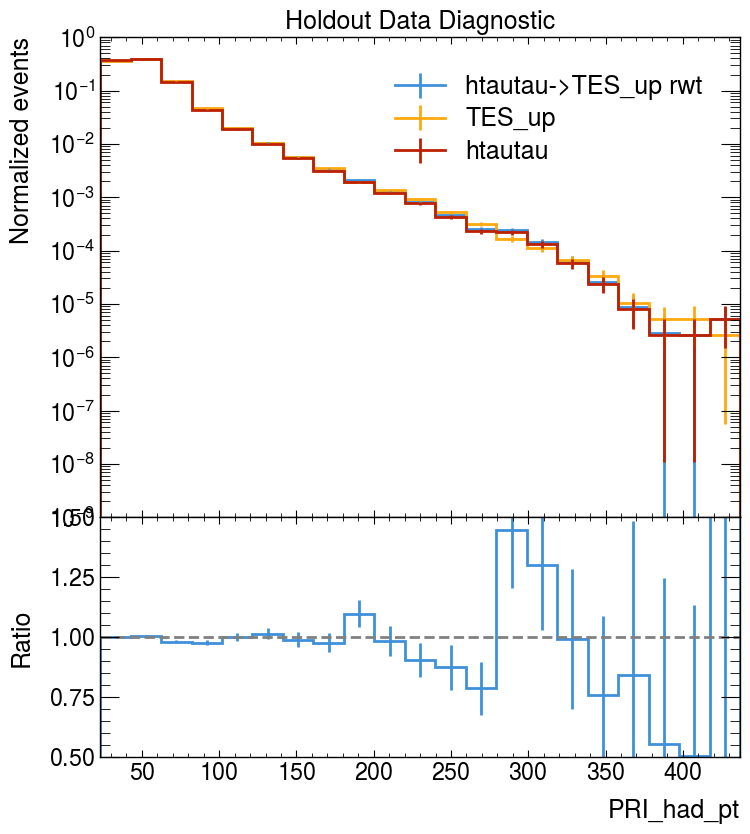

<Figure size 800x600 with 0 Axes>

In [26]:
variables_to_plot=['PRI_had_pt'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_syst_process["htautau"]["TES"]["up"].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


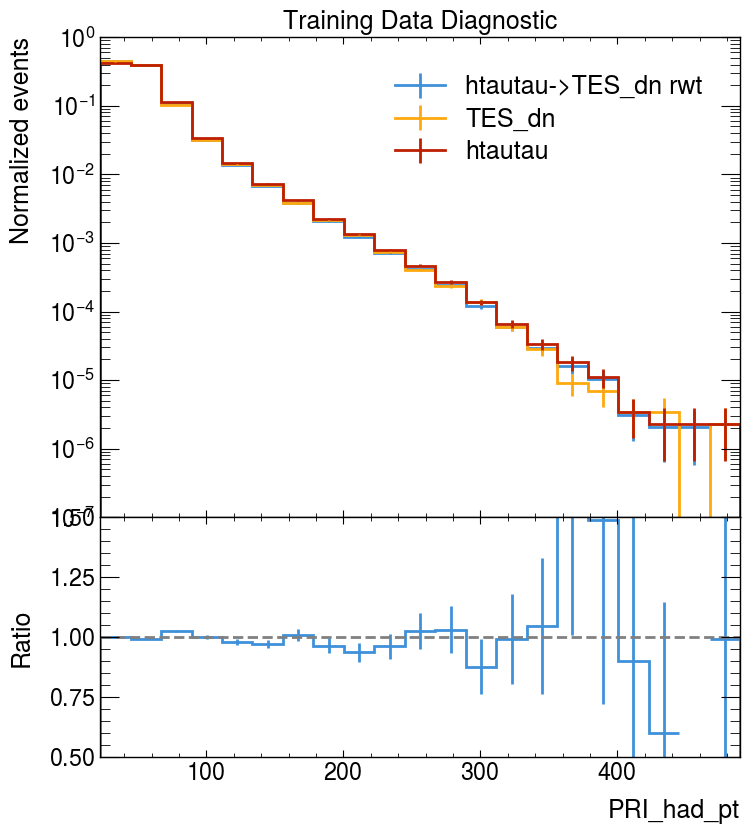

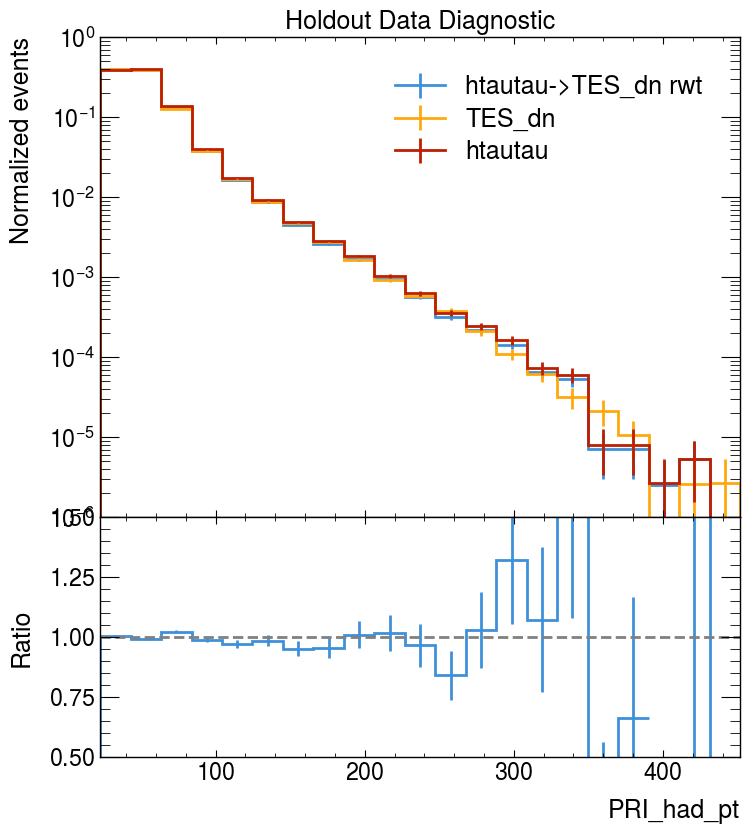

<Figure size 800x600 with 0 Axes>

In [27]:
variables_to_plot=['PRI_had_pt'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_syst_process["htautau"]["TES"]["dn"].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


Save the model output
--

Save the density ratios corresponding to each NP $\alpha_m$ and process $p_c(x)$ as a set of `numpy` arrays for use in the `Parameter_Fitting_with_Systematics.ipynb` notebook.

The trained models are also saved automatically by the training class for direct use in inference, or for evaluating on real data.

In [28]:
dataset_eval = pd.read_hdf(f"{saved_data}dataset_preselected_nominal_SR.h5", key="dataset", mode='r')

for process in labels_dict:
    
    for syst in dict_systs:

        if process not in dict_systs[syst]['process']:
            print(f"Nothing to evaluate for {process} in {syst} uncertainty")
            continue
        
        for direction in dict_systs[syst]['directions']:

            # Evaluate the density ratios p_alpha^\pm/p_nom for the nominal dataset
            NN_training_syst_process[process][syst][direction].evaluate_and_save_ratios(dataset_eval)


197/197 - 2s - 9ms/step
197/197 - 2s - 9ms/step
197/197 - 2s - 9ms/step
197/197 - 2s - 9ms/step
197/197 - 2s - 9ms/step
197/197 - 2s - 9ms/step


In [29]:
# Save the systematic variation on total yields in the SR
nu_var_SR = {}
for process in labels_dict:

    mask_process_nom = dataset_nom_channels['SR'].type==process
    nu_var_SR[process] = {}
    
    for syst in dict_systs:

        nu_var_SR[process][syst] = {}
        
        for direction in dict_systs[syst]['directions']:
            
            if process not in dict_systs[syst]['process']:
                nu_var_SR[process][syst][direction] = 1.0
            else:
                
                mask_process_syst = (datasets_syst_channels[syst][direction]['SR'].type==process)
                
                nu_var_SR[process][syst][direction] = datasets_syst_channels[syst][direction]['SR'][mask_process_syst].weights.sum() / dataset_nom_channels['SR'][mask_process_nom].weights.sum()
                if 'down' not in dict_systs[syst]['directions']:
                    nu_var_SR[process][syst]['down'] = 2.0 - nu_var_SR[process][syst]['up']
                    
                

In [30]:
# Save the Control Region variation histogram
with open(f"{saved_data}yield_SR_variations.pkl", "wb") as fp:
    pickle.dump(nu_var_SR, fp)